# Overview
In this workbook, we'll leverage Sklearn's TFIDF vectorizer and MiniBatchKmeans to perform some simple document clustering. After which , we'll plot the clusters using PCA and TSNE, then show the top keywords in each cluster.

In [49]:
import os
import re
import csv
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Importing the data
Importing the data is simple with Pandas. The source file is a newline delimited JSON file

In [73]:
data = pd.read_csv('crawling_berita/Detik/detik_covid.csv', encoding = "ISO-8859-1")

newsTotal=[]
for news in data.content.values:
    newsTotal.append(news)

newsTotal

[' Yogyakarta Warga di wilayah Solo Raya dikagetkan penampakan benda asing di langit Minggu siang Benda berjumlah sekitar delapan buah tersebut tampak bercahaya hingga tak sedikit warga yang mengira penampakan tersebut adalah bintang Peristiwa itu terekam warga dan videonya viral Dalam video tersebut benda itu terlihat sangat kecil Warga yang merekam kejadian tersebut sempat menghitung ada empat hingga delapan benda yang belum teridentifikasi itu Sejumlah warga membenarkan adanya kejadian tersebut Salah satunya warga Sawit Kabupaten Boyolali Rahma yang mengaku melihat langsung kejadian itu sekitar pukul WIB Awalnya saya lihat di story WhatsApp teman teman Lalu saya cek ternyata masih terlihat Keluarga saya juga lihat kata Rahma saat dihubungi detikcom Minggu Warga Manahan Solo Teguh juga melihat dan merekam penampakan benda misterius itu Bukan hanya empat dia malah menghitung ada tujuh benda Dari medsos itu saya cek ternyata benar Awalnya cuma lihat satu tapi saya cek lagi ketemu tujuh

## Preprocess Data

In [79]:
def casefolding(sentence):
    return sentence.lower()

def cleaning(sentence):
    return re.sub(r'[^a-z]', ' ', re.sub("’", '', sentence))

def tokenization(sentence):
    return sentence.split()

def stopword_removal(token):
    temp = []
    for i in range(len(token)):
        if token[i] not in stopwords:
            temp.append(token[i])
    return temp

def sentence_split(paragraph):
    return nltk.sent_tokenize(paragraph)

newsPrep=[]
for news in newsTotal:
    newsPrep.append(tokenization(cleaning(casefolding(news))))

newsPrep

[['yogyakarta',
  'warga',
  'di',
  'wilayah',
  'solo',
  'raya',
  'dikagetkan',
  'penampakan',
  'benda',
  'asing',
  'di',
  'langit',
  'minggu',
  'siang',
  'benda',
  'berjumlah',
  'sekitar',
  'delapan',
  'buah',
  'tersebut',
  'tampak',
  'bercahaya',
  'hingga',
  'tak',
  'sedikit',
  'warga',
  'yang',
  'mengira',
  'penampakan',
  'tersebut',
  'adalah',
  'bintang',
  'peristiwa',
  'itu',
  'terekam',
  'warga',
  'dan',
  'videonya',
  'viral',
  'dalam',
  'video',
  'tersebut',
  'benda',
  'itu',
  'terlihat',
  'sangat',
  'kecil',
  'warga',
  'yang',
  'merekam',
  'kejadian',
  'tersebut',
  'sempat',
  'menghitung',
  'ada',
  'empat',
  'hingga',
  'delapan',
  'benda',
  'yang',
  'belum',
  'teridentifikasi',
  'itu',
  'sejumlah',
  'warga',
  'membenarkan',
  'adanya',
  'kejadian',
  'tersebut',
  'salah',
  'satunya',
  'warga',
  'sawit',
  'kabupaten',
  'boyolali',
  'rahma',
  'yang',
  'mengaku',
  'melihat',
  'langsung',
  'kejadian',
  'it

## Extracting keywords
Here I use the TfidfVectorizer since I'm hoping the IDF score will pull out unique words that I can use in clustering. There are lots of options to explore here to get different results, including CountVectorizer

In [80]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data.content)
text = tfidf.transform(newsPrep)

AttributeError: 'list' object has no attribute 'lower'

## Finding Optimal Clusters
Clustering is an unsupervised operation, and KMeans requires that we specify the number of clusters. One simple approach is to plot the SSE for a range of cluster sizes. We look for the "elbow" where the SSE begins to level off. MiniBatchKMeans introduces some noise so I raised the batch and init sizes higher. Unfortunately the regular Kmeans implementation is too slow. You'll notice different random states will generate different charts. Here I chose 14 clusters.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


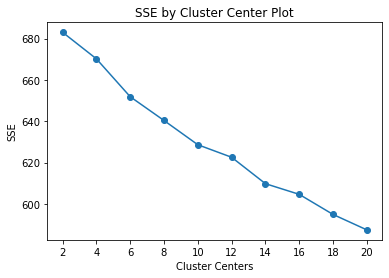

In [75]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [76]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

## Plotting Clusters
Here we plot the clusters generated by our KMeans operation. One plot uses PCA which is better at capturing global structure of the data. The other uses TSNE which is better at capturing relations between neighbors. In order to speed up the process with TSNE, I sample from 3,000 documents and perform a PCA 50 dimension reduction on the data first. Next I show a scatterplot further sampling the sample down to 300 points.

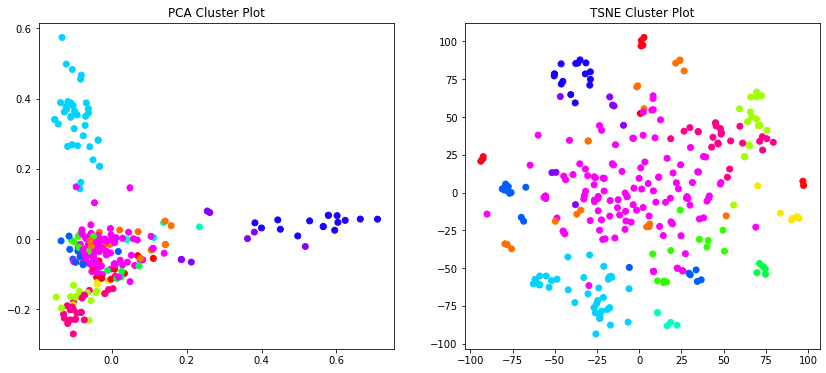

In [77]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)
    

## Top Keywords
Lastly, we'll cycle through the clusters and print out the top keywords based on their TFIDF score to see if we can spot any trends. I'll do this by computing an average value across all dimensions in Pandas, grouped by the cluster label. Using numpy, finding the top words is simply sorting the average values for each row, and taking the top N.

You can see that we have a pretty good result. Topics including exploitation of children, tax fraud, civil rights, and environmental issues can be inferred from the top keywords. Other interesting approaches to this might include LDA topic modeling or possibly working with pre-trained word embeddings.

In [27]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 20)


Cluster 0
lockdown,meninggal,negeri,sun,bdh,pegawai,ditutup,birojatim,terpapar,positif,pegawainya,pn,kantor,agama,klaster,covid,hakim,perkantoran,pengadilan,banyuwangi

Cluster 1
ini,forbes,bansos,dan,bambang,pesta,virus,daftar,dari,indonesia,google,di,covid,yang,orang,rp,alat,tes,terkaya,corona

Cluster 2
bogor,yang,melakukan,tegas,polisi,jakarta,kapolda,di,swab,tersangka,petamburan,kerumunan,shihab,fpi,ormas,polda,jaya,metro,habib,rizieq

Cluster 3
cepat,pilbup,hitung,menang,tangsel,yang,persen,calon,dan,hasil,suara,kemenangan,kpu,serentak,di,quick,paslon,pasangan,count,pilkada

Cluster 4
tahun,dana,juta,keuangan,penerima,indonesia,triliun,blt,untuk,anggaran,bansos,ekonomi,rp,umkm,yang,investasi,dan,bantuan,bank,program

Cluster 5
pulih,lagi,doa,pribadinya,instagram,puji,akun,dan,fadhil,ia,syariah,segala,covid,corona,allah,saham,positif,ustaz,yusuf,mansur

Cluster 6
tanda,infeksi,seseorang,kebingungan,dialami,kondisi,bisa,menemukan,peneliti,persen,mata,yang,virus,tenggorokan,sakit,c